# <b><span style="color:red"> Font classification</span></b>

In [1]:
#loading libraries
from PIL import Image, ImageDraw, ImageFont
import os
import random
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2
import torch.utils.data as data
from torchvision.datasets import ImageFolder
import warnings
import wandb
warnings.filterwarnings("ignore")
from performance_measure import calculate_metrics
random.seed(42)

## 1. Exploring Data

In [2]:
#defining the paths
#project path
project_files_path = os.path.join(os.getcwd(), "project_files")
#data path
data_path = os.path.join(project_files_path, "data")
#synthetic data path
#this path will be used to store the synthetic data and will be created during the execution of the code
synthetic_data_path = os.path.join(project_files_path, "synthetic_data_demo")
#google 10k most common words txt file path
google_10k_words_path = os.path.join(project_files_path, "google-10000-english-preprocessed.txt")

In [3]:
#first getting all the different font classes in the data
def get_folder_names(font_data_path):
    if not os.path.exists(font_data_path):
        print("Font Data folder does not exist. Please specify correct path to the font data folder.")
        return
    folder_names = []
    for root, dirs, files in os.walk(font_data_path):
        for dir in dirs:
            folder_names.append(dir)
    return folder_names

font_names = get_folder_names(data_path)
print(font_names)

['AlexBrush', 'I Love Glitter', 'Holligate Signature', 'Canterbury', 'AguafinaScript', 'James Fajardo', 'GreatVibes', 'Allura', 'alsscrp', 'OpenSans']


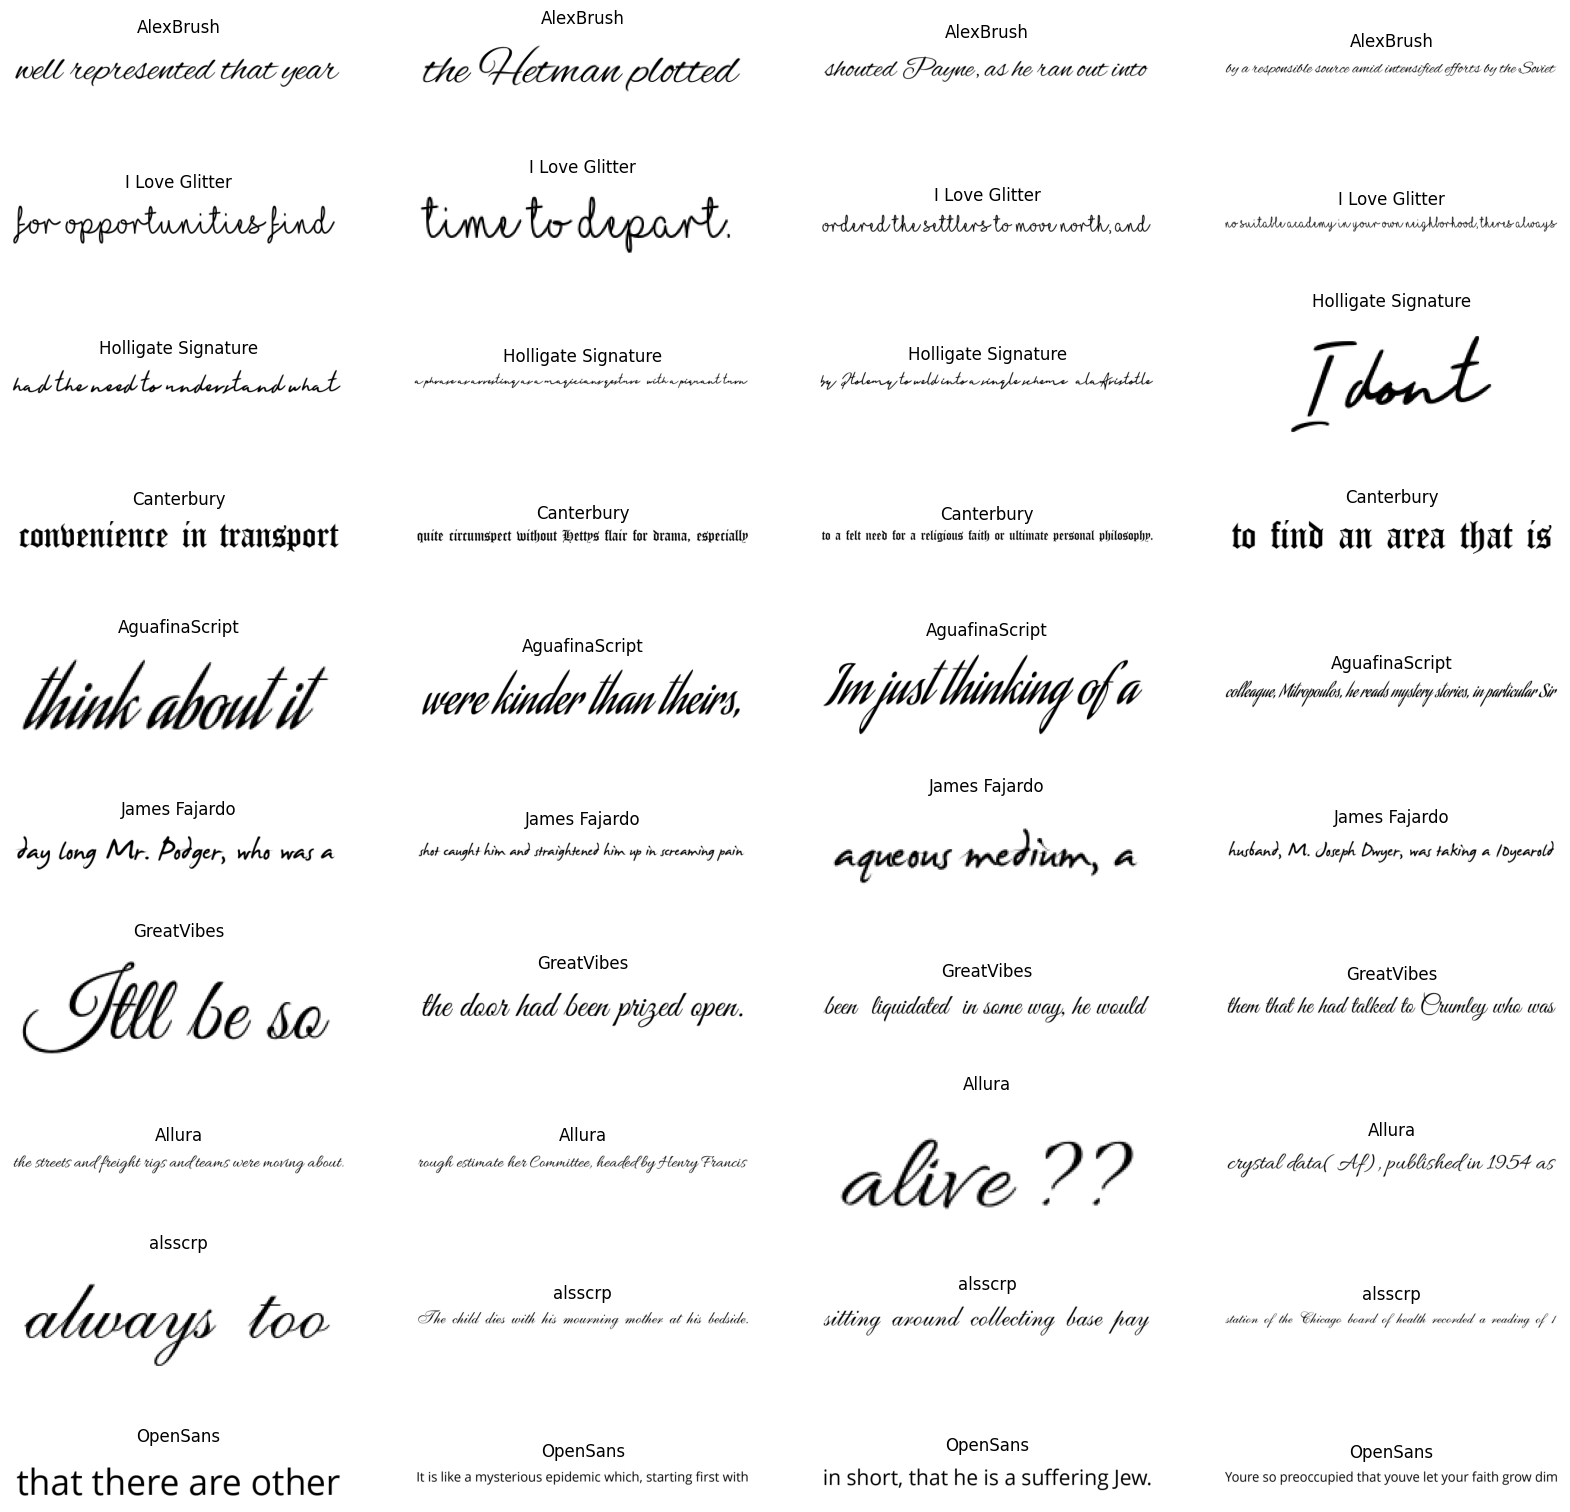

In [4]:
#displaying a few sample images for each font
plt.figure(figsize=(20,20))
for i,folder in enumerate(font_names):
    images=os.listdir(os.path.join(data_path,folder))
    for j in range(4):
        img=cv2.imread(os.path.join(data_path,folder,images[j]))
        #use matplotlib to display images
        plt.subplot(10,4,i*4+j+1)
        plt.imshow(img)
        plt.title(folder)
        plt.axis('off')
plt.show()

## 2. Splitting the dataset in Train, Val and Test

In [5]:
#first thigs first, splitting the data to avoid data leakage


def splitting_data(font_data_path, train_ratio=0.8, test_ratio=0.1, val_ratio=0.1):
    """
    Splits the data into train, test and validation sets for each font.
    """
    font_names_list = get_folder_names(font_data_path)
    print('Total number of fonts in dataset:', len(font_names_list))
    
    # Create folders for train, test and val data for each font
    for font_name in font_names_list:
        os.makedirs(os.path.join(project_files_path, synthetic_data_path, "train", font_name), exist_ok=True)
        os.makedirs(os.path.join(project_files_path, synthetic_data_path, "test", font_name), exist_ok=True)
        os.makedirs(os.path.join(project_files_path, synthetic_data_path, "val", font_name), exist_ok=True)
        # Get all the images in the font folder
        images = os.listdir(os.path.join(project_files_path, "data", font_name))
        random.shuffle(images)
        train_images = images[:int(len(images) * train_ratio)]
        test_images = images[int(len(images) * train_ratio):int(len(images) * (train_ratio + test_ratio))]
        val_images = images[int(len(images) * (train_ratio + test_ratio)):]
        # Check there are no common images in the train, test and val sets
        assert len(set(train_images).intersection(set(test_images))) == 0
        assert len(set(train_images).intersection(set(val_images))) == 0
        assert len(set(test_images).intersection(set(val_images))) == 0

        # Copy the images to the respective folders
        for image in train_images:
            shutil.copy(os.path.join(project_files_path, "data", font_name, image),
                        os.path.join(project_files_path, synthetic_data_path, "train", font_name, image))
        for image in test_images:
            shutil.copy(os.path.join(project_files_path, "data", font_name, image),
                        os.path.join(project_files_path, synthetic_data_path, "test", font_name, image))
        for image in val_images:
            shutil.copy(os.path.join(project_files_path, "data", font_name, image),
                        os.path.join(project_files_path, synthetic_data_path, "val", font_name, image))
        print(f"Created folders for font {font_name} with {len(train_images)} train images, {len(val_images)} val images, and {len(test_images)} test images.")
    print('-' * 50)
    print(f'Splitting done. Train, test and val data saved in {synthetic_data_path} folder.')


In [6]:
splitting_data(data_path)

Total number of fonts in dataset: 10
Created folders for font AlexBrush with 66 train images, 9 val images, and 8 test images.
Created folders for font I Love Glitter with 61 train images, 8 val images, and 8 test images.
Created folders for font Holligate Signature with 69 train images, 9 val images, and 9 test images.
Created folders for font Canterbury with 64 train images, 9 val images, and 8 test images.
Created folders for font AguafinaScript with 70 train images, 9 val images, and 9 test images.
Created folders for font James Fajardo with 68 train images, 9 val images, and 8 test images.
Created folders for font GreatVibes with 64 train images, 9 val images, and 8 test images.
Created folders for font Allura with 60 train images, 8 val images, and 7 test images.
Created folders for font alsscrp with 85 train images, 11 val images, and 11 test images.
Created folders for font OpenSans with 62 train images, 8 val images, and 8 test images.
-----------------------------------------

## 3. Creating Synthetic data

In [7]:
#reading the google 10k most common words
def read_google_10k_words(google_10k_words_path):
    with open(google_10k_words_path, 'r') as f:
        words = f.readlines()
        words = [word.strip() for word in words]
    return words

words = read_google_10k_words(google_10k_words_path)
print('Total number of words in the google 10k most common words:', len(words))
print('First 10 words:', words[:10])
print('Last 10 words:', words[-10:])

Total number of words in the google 10k most common words: 10149
First 10 words: ['the', 'of', 'and', 'to', 'a', 'in', 'is', 'on', 'by', 'this']
Last 10 words: ['Yarn', 'conditional.', 'Budapest', 'attacked,', 'fares,', 'Telecharger', 'Safer', 'Ranger', 'Robbie', 'varieties9']


In [8]:
def get_num_chars(width):
    """
    Returns the number of characters to be generated in the image based on the width of the image.
    """
    num_chars=(width//22)+random.randint(-2,2)
    return max(5,num_chars)
    
def generate_string(num_chars):
    """
    Returns a string of words with the total number of characters equal to or less than num_chars.
    Words are randomly selected from the list of preprocessed English words. 
    """
    result = ''
    random.shuffle(words) 
    result = ''
    random.shuffle(words) 
    while len(result) < num_chars:
            random_word = random.choice(words)
            if len(result) + len(random_word) <= num_chars:
                result += random_word + ' '
            else:
                if abs(len(result) + len(random_word) - num_chars) < 3:
                    break
                else:
                    random_word = random.choice([word for word in words if len(word) <= (num_chars - len(result))])
                    result += random_word + ' '     
    return result.strip()

In [9]:
#getting a random image
img_path=os.path.join(data_path, "OpenSans", "image_0.png")
img = Image.open(img_path)
#getting the width of the image
width, height = img.size
print('Width:', width)
#getting the number of characters to be generated
num_chars = get_num_chars(width)
print('Number of characters:', num_chars)
#generating the string
string = generate_string(num_chars)
print('String:', string)

Width: 1126
Number of characters: 51
String: aerial bright respected Formula male wax dealer Mod


In [10]:
def generate_sample_font_images(font_name, num_samples_per_image_train, num_samples_per_iamge_val):
    """
        Generate the synthetic images for the given font name.
        First the ttf file is loaded for the corresponding font name.
        For each image (num_samples) images are created.
        The width and height of the generated image is the same as the original image.
        Using the width of the image, the number of characters that can fit in the image is calculated.
        A random string of words is generated that is less than or equal to the number of characters.
        The font size is calculated such that the text fits in the image.
        The text is drawn on the image after appropriate scalling and positioning.
        Finally the image is saved in the synthetic_data folder.
    """
    os.makedirs(os.path.join(project_files_path, synthetic_data_path, "synthetic_train", font_name), exist_ok=True)
    os.makedirs(os.path.join(project_files_path, synthetic_data_path, "synthetic_val", font_name), exist_ok=True)
    font_data_folder_train = os.path.join(project_files_path, synthetic_data_path, "train", font_name)
    font_data_folder_val = os.path.join(project_files_path, synthetic_data_path, "val", font_name)
    # Using the ttf file for generating images
    font_path = os.path.join(project_files_path, "fonts", font_name + '.ttf')

    print(f'Using {font_path} for generating images.')
    font_size = 72

    font_files_train = [os.path.join(font_data_folder_train, font_file) for font_file in os.listdir(font_data_folder_train)]
    font_files_val = [os.path.join(font_data_folder_val, font_file) for font_file in os.listdir(font_data_folder_val)]

    files = {'train': font_files_train, 'val': font_files_val}
    num_files = {'train': num_samples_per_image_train, 'val': num_samples_per_iamge_val}
    new_files_generated = 0
    for key in files.keys():
        for font_file in tqdm((files[key])):
            # print('Processing:',font_file)
            img = Image.open(font_file)
            width, height = img.size
            # save the current file
            if key == 'train':
                new_path = font_file.replace('train', 'synthetic_train')
            else:
                new_path = font_file.replace('val', 'synthetic_val')
            # print('Saving to:',new_path)
            img.save(new_path)

            # generate new images
            for i in range(num_files[key]):
                font = ImageFont.truetype(font_path, font_size)
                num_chars = get_num_chars(width)
                # generate the text
                text = generate_string(num_chars)
                # draw the text on the image
                image = Image.new("RGB", (width, height), "white")
                draw = ImageDraw.Draw(image)
                text_length = draw.textlength(text, font=font)
                # reduce the font size if the text is too long``
                while text_length > width:
                    font_size -= 1
                    font = ImageFont.truetype(font_path, font_size)
                    text_length = draw.textlength(text, font=font)
                font_size += 1
                font = ImageFont.truetype(font_path, font_size)
                text_position = (image.width // 2, image.height // 2)
                draw.text(text_position, text, fill="black", font=font, anchor="mm")
                try:
                    image.save(new_path.replace('.png', f'_{i}.png'))
                    new_files_generated += 1
                except:
                    print('Error saving image for')
                    print(font_file)
    print(f'Generated {new_files_generated} new images for {font_name}')
    print('-' * 50)


In [11]:
num_samples_per_image_train = 5
num_samples_per_image_val = 2
for font in font_names:
    generate_sample_font_images(font, num_samples_per_image_train, num_samples_per_image_val)
print(f'Generated synthetic images in {synthetic_data_path} folder.')

Using /Users/kunalmishra/Desktop/font_classifier/project_files/fonts/AlexBrush.ttf for generating images.


100%|██████████| 9/9 [00:00<00:00, 52.42it/s]


Generated 348 new images for AlexBrush
--------------------------------------------------
Using /Users/kunalmishra/Desktop/font_classifier/project_files/fonts/I Love Glitter.ttf for generating images.


100%|██████████| 8/8 [00:00<00:00, 39.88it/s]


Generated 321 new images for I Love Glitter
--------------------------------------------------
Using /Users/kunalmishra/Desktop/font_classifier/project_files/fonts/Holligate Signature.ttf for generating images.


100%|██████████| 9/9 [00:00<00:00, 32.13it/s]


Generated 363 new images for Holligate Signature
--------------------------------------------------
Using /Users/kunalmishra/Desktop/font_classifier/project_files/fonts/Canterbury.ttf for generating images.


100%|██████████| 9/9 [00:00<00:00, 48.08it/s]


Generated 338 new images for Canterbury
--------------------------------------------------
Using /Users/kunalmishra/Desktop/font_classifier/project_files/fonts/AguafinaScript.ttf for generating images.


100%|██████████| 9/9 [00:00<00:00, 48.32it/s]


Generated 368 new images for AguafinaScript
--------------------------------------------------
Using /Users/kunalmishra/Desktop/font_classifier/project_files/fonts/James Fajardo.ttf for generating images.


100%|██████████| 9/9 [00:00<00:00, 65.81it/s]


Generated 358 new images for James Fajardo
--------------------------------------------------
Using /Users/kunalmishra/Desktop/font_classifier/project_files/fonts/GreatVibes.ttf for generating images.


100%|██████████| 9/9 [00:00<00:00, 46.81it/s]


Generated 338 new images for GreatVibes
--------------------------------------------------
Using /Users/kunalmishra/Desktop/font_classifier/project_files/fonts/Allura.ttf for generating images.


100%|██████████| 8/8 [00:00<00:00, 44.83it/s]


Generated 316 new images for Allura
--------------------------------------------------
Using /Users/kunalmishra/Desktop/font_classifier/project_files/fonts/alsscrp.ttf for generating images.


100%|██████████| 11/11 [00:00<00:00, 37.97it/s]


Generated 447 new images for alsscrp
--------------------------------------------------
Using /Users/kunalmishra/Desktop/font_classifier/project_files/fonts/OpenSans.ttf for generating images.


100%|██████████| 8/8 [00:00<00:00, 36.14it/s]

Generated 326 new images for OpenSans
--------------------------------------------------
Generated synthetic images in /Users/kunalmishra/Desktop/font_classifier/project_files/synthetic_data_demo folder.


## 4. Defining the models

In [12]:
#model 1
#using lenet architecture model to train on the synthetic data
class LeNet(nn.Module):
    """
    LeNet model with all the layers defined, ready to be trained from scratch
    """
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(6)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.layer2 = nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(3136 , 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        out=self.layer1(x)
        out=self.batchnorm1(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.layer2(out)
        out=self.batchnorm2(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [13]:
seq_model_1 = LeNet(num_classes=len(font_names))
num_params = sum(p.numel() for p in seq_model_1.parameters() if p.requires_grad)
print('Number of parameters in the model:', num_params)

Number of parameters in the model: 204162


In [14]:
#model 2
#instead of training the model from scratch, we can use a pre-trained model and fine-tune it on the synthetic data
#using resnet18 architecture model to train on the synthetic data
class CustomResNet:
    """
    Custom ResNet model with the desired number of output classes
    """
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def get_model(self):
        seq_model = models.resnet18(pretrained=True)
        for param in seq_model.parameters():
            param.requires_grad = False
        #modifying the last layer to have the desired number of output classes
        num_ftrs = seq_model.fc.in_features
        seq_model.fc = nn.Linear(num_ftrs, self.num_classes)
        return seq_model

In [15]:
seq_model_2 = CustomResNet(num_classes=len(font_names)).get_model()
num_params = sum(p.numel() for p in seq_model_2.parameters())
print('Number of parameters in the model:', num_params)
trainable_params = sum(p.numel() for p in seq_model_2.parameters() if p.requires_grad)
print('Number of trainable parameters in the model:', trainable_params)

Number of parameters in the model: 11181642
Number of trainable parameters in the model: 5130


## 5. Defining the Performance metrics

In [16]:
def compute_recall_precison_f1(num_classes, all_labels, all_preds):
    """
    Compute recall, precision and f1 score for each class and return the macro average of the same.
    """
    classes_present = num_classes
    total_recall = 0
    for i in range(num_classes):
        tp = torch.sum((all_labels == i) & (all_preds == i))
        fn = torch.sum((all_labels == i) & (all_preds != i))
        if tp + fn != 0:
            recall = tp / (tp + fn)
        else:
            recall = 0
        total_recall += recall
    macro_recall = total_recall / classes_present
    print("Macro recall : {:.4f}".format(macro_recall), end=', ')

    # Macro Precision
    total_precision = 0
    for i in range(num_classes):
        tp = torch.sum((all_labels == i) & (all_preds == i))
        fp = torch.sum((all_labels != i) & (all_preds == i))
        if tp + fp != 0:
            precision = tp / (tp + fp)
        else:
            precision = 0
        total_precision += precision
    macro_precision = total_precision / classes_present
    print("Macro precision : {:.4f}".format(macro_precision), end=', ')
    macro_f1 = (2 * macro_precision * macro_recall) / (macro_precision + macro_recall)
    print("Macro f1 : {:.4f}".format(macro_f1))
    return macro_recall, macro_precision, macro_f1

In [17]:
@torch.no_grad()
def calculate_metrics(eval_dataloader,seq_model):
    """
    Calculate the accuracy, precision, recall and f1 score for the model on the input dataloader
    """
    cross_entropy_loss = torch.nn.CrossEntropyLoss()
    seq_model.eval()
    correct = 0
    total = 0
    total_loss=0
    # Initialize the lists to store the labels and predictions for all points in the dataloader
    all_labels = torch.zeros(len(eval_dataloader.dataset))
    all_preds = torch.zeros(len(eval_dataloader.dataset))
    for i,(images, labels) in enumerate(eval_dataloader):
                # Move the batch to the GPU if available
                curr_index = i*batch_size
                images = images.to(device)
                seq_model.to(device)
                # Forward pass and prediction
                outputs = seq_model(images)
                outputs = outputs.cpu().detach()
                _, predicted_label = torch.max(outputs.data, 1)
                labels= labels.cpu().detach()
                #computing loss
                total_loss+=cross_entropy_loss(outputs,labels)

                # Compute accuracy
                total += labels.size(0)
                correct += (predicted_label == labels).sum().item()
                # Store the labels and predictions for current batch
                all_labels[curr_index:(curr_index+len(labels))] = labels
                all_preds[curr_index:(curr_index+len(labels))] = predicted_label
            #average loss
    average_loss=(total_loss/len(eval_dataloader))
    print('Avergae loss {:.4f}'.format(average_loss),end = ' , ')
    # Validation Accuracy
    val_accuracy = 100 * correct / total
    print('Accuracy: {:.2f}%'.format(val_accuracy),end = ' , ')
    #macro recall
    macro_recall, macro_precision,macro_f1=compute_recall_precison_f1(num_classes,all_labels,all_preds)
    out = {
                'accuracy': val_accuracy,
                'precision': macro_precision,
                'recall': macro_recall,
                'f1_score': macro_f1,
                'loss': average_loss
            }
    seq_model.train()
    return out


## 6. Loading the dataset

In [18]:
data_transforms = v2.Compose([
        v2.Grayscale(), #required for training lenet; comment out for resnet and efficient net
        v2.RandomRotation(15, expand=True),
        v2.ColorJitter(brightness=(1,15)),
        v2.GaussianBlur(5),
        v2.Resize((64, 64)),
        v2.ToTensor(),
        #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        v2.Normalize(mean=[0.5], std=[0.5])
    ])

def get_dataloader(data_path,label):
    """
    Create a dataloader for the input dataset given the path and label
    """
    if(label=='True'):
        shuffle=True
    else:
        shuffle=False
    dataset = ImageFolder(data_path, transform=data_transforms)
    image_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    print(f'Number of points in {label} dataset - ', len(dataset))
    return image_loader

# Loading the training and validation datasets and creating dataloaders
batch_size=32
train_path = os.path.join('project_files',synthetic_data_path, 'synthetic_train')
train_loader = get_dataloader(train_path,'train')
val_path = os.path.join('project_files',synthetic_data_path, 'synthetic_val')
val_loader = get_dataloader(val_path,'val')
test_path=  os.path.join('project_files',synthetic_data_path, 'test')
test_loader = get_dataloader(test_path,'test')

Number of points in train dataset -  3993
Number of points in val dataset -  266
Number of points in test dataset -  84


## 7. Training the Model

### 7.1 Training the LeNet model

In [19]:
def model_train(n_epochs,train_loader,val_loader,seq_model,cross_entropy_loss,optimizer,best_val_f1=-10000,device='cpu'):
    """
    Train the model for n_epochs on the training set
    """
    for epoch in range(n_epochs):
        # Set the model to train mode

        # Loop over the training data in batches
        for i, (images, labels) in enumerate(train_loader):
            # Move the batch to the GPU if available
            images = images.to(device)  # batch_size,num_channels,resize_height,resize_width
            #print(images.shape)
            labels = labels.to(device) # 1xbatch_size
            seq_model.to(device)
            # Forward pass
            outputs = seq_model(images)   # [batch_size, num_classes]
            loss = cross_entropy_loss(outputs, labels)

            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if(i+1)%100==0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, i+1, len(train_loader), loss.item()))
        # Evaluate the model on the training, validation and test sets
        print('Val',end=' - ')
        out_val=calculate_metrics(val_loader,seq_model)
        print('Test',end= ' - ')
        out_test=calculate_metrics(test_loader,seq_model)

In [20]:
#device='cuda' if torch.cuda.is_available() else 'cpu'
device= 'mps' if torch.backends.mps.is_available() else 'cpu'
seq_model_1.to(device)

cross_entropy_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(seq_model_1.parameters(), lr=0.003)
n_epochs = 5
num_classes=10
model_train(n_epochs, train_loader, val_loader, seq_model_1, cross_entropy_loss, optimizer)
#the performace will be very low as the model is trained on very less data
#models' performance can be improved by creating more synthetic data
#a better trained lenet model is saved in the saved_models folder of the repo

Epoch [1/5], Step [100/125], Loss: 71.4023
Val - Avergae loss 34.9919 , Accuracy: 12.41% , Macro recall : 0.1000, Macro precision : 0.0124, Macro f1 : 0.0221
Test - Avergae loss 36.4187 , Accuracy: 13.10% , Macro recall : 0.1000, Macro precision : 0.0131, Macro f1 : 0.0232
Epoch [2/5], Step [100/125], Loss: 6.7692
Val - Avergae loss 9.8940 , Accuracy: 12.41% , Macro recall : 0.1000, Macro precision : 0.0124, Macro f1 : 0.0221
Test - Avergae loss 9.6742 , Accuracy: 13.10% , Macro recall : 0.1000, Macro precision : 0.0131, Macro f1 : 0.0232
Epoch [3/5], Step [100/125], Loss: 5.1644
Val - Avergae loss 2.4909 , Accuracy: 12.41% , Macro recall : 0.1000, Macro precision : 0.0125, Macro f1 : 0.0222
Test - Avergae loss 2.4591 , Accuracy: 13.10% , Macro recall : 0.1000, Macro precision : 0.0131, Macro f1 : 0.0232
Epoch [4/5], Step [100/125], Loss: 3.4796
Val - Avergae loss 2.4619 , Accuracy: 11.65% , Macro recall : 0.0951, Macro precision : 0.0164, Macro f1 : 0.0280
Test - Avergae loss 2.3880 ,

### 7.2 Finetuning Resnet model

In [21]:
#for LeNet model we enabled grayscale transformation in the data loader
#for all other models, we need to comment out the grayscale transformation in the data loader
#loading the data again
data_transforms = v2.Compose([
        #v2.Grayscale(), #required for training lenet; comment out for resnet and efficient net
        v2.RandomRotation(15, expand=True),
        v2.ColorJitter(brightness=(1,15)),
        v2.GaussianBlur(5),
        v2.Resize((64, 64)),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        #v2.Normalize(mean=[0.5], std=[0.5])
    ])

def get_dataloader(data_path,label):
    """
    Create a dataloader for the input dataset given the path and label
    """
    if(label=='True'):
        shuffle=True
    else:
        shuffle=False
    dataset = ImageFolder(data_path, transform=data_transforms)
    image_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    print(f'Number of points in {label} dataset - ', len(dataset))
    return image_loader

# Loading the training and validation datasets and creating dataloaders
batch_size=32
train_path = os.path.join('project_files',synthetic_data_path, 'synthetic_train')
train_loader = get_dataloader(train_path,'train')
val_path = os.path.join('project_files',synthetic_data_path, 'synthetic_val')
val_loader = get_dataloader(val_path,'val')
test_path=  os.path.join('project_files',synthetic_data_path, 'test')
test_loader = get_dataloader(test_path,'test')

Number of points in train dataset -  3993
Number of points in val dataset -  266
Number of points in test dataset -  84


In [22]:
#device='cuda' if torch.cuda.is_available() else 'cpu'
device= 'mps' if torch.backends.mps.is_available() else 'cpu'
seq_model_2.to(device)

cross_entropy_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(seq_model_2.parameters(), lr=0.003)
n_epochs = 5
num_classes=10
model_train(n_epochs, train_loader, val_loader, seq_model_2, cross_entropy_loss, optimizer)
#the performace will be very low as the model is trained on very less data
#to improve the performance the model can be trained more data 
#we can also train the model for more epochs and with a lower learning rate
#a better finetuned resnet model is saved in the saved_models folder of the repo

Epoch [1/5], Step [100/125], Loss: 32.2372
Val - Avergae loss 29.0889 , Accuracy: 12.41% , Macro recall : 0.1000, Macro precision : 0.0124, Macro f1 : 0.0221
Test - Avergae loss 27.9761 , Accuracy: 13.10% , Macro recall : 0.1000, Macro precision : 0.0131, Macro f1 : 0.0232
Epoch [2/5], Step [100/125], Loss: 20.5649
Val - Avergae loss 18.1303 , Accuracy: 12.41% , Macro recall : 0.1000, Macro precision : 0.0124, Macro f1 : 0.0221
Test - Avergae loss 19.0075 , Accuracy: 13.10% , Macro recall : 0.1000, Macro precision : 0.0131, Macro f1 : 0.0232
Epoch [3/5], Step [100/125], Loss: 29.4169
Val - Avergae loss 19.6719 , Accuracy: 12.41% , Macro recall : 0.1000, Macro precision : 0.0124, Macro f1 : 0.0221
Test - Avergae loss 19.9757 , Accuracy: 13.10% , Macro recall : 0.1000, Macro precision : 0.0131, Macro f1 : 0.0232
Epoch [4/5], Step [100/125], Loss: 18.7841
Val - Avergae loss 19.0341 , Accuracy: 12.41% , Macro recall : 0.1000, Macro precision : 0.0124, Macro f1 : 0.0221
Test - Avergae loss 